<h1>Deep learning project 8DM20 CSMIA</h1>

<h4>Group members:</h4>
O. Akdag - 0842508 <br>
T.P.A. Beishuizen - 0791613 <br>
A.S.A. Eskelinen - 1224333 <br>
J.H.A. Migchielsen - 0495058 <br>
L. van den Wildenberg - 0844697 <br>

In [1]:
# Import all used packages (unused packages are commented out so far)
import os
from PIL import Image as PIL_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.feature_extraction import image as sklearn_image
%matplotlib inline
import theano
import lasagne
import time
import random
random.seed(0)

C:\Users\Atte\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Before everything can be done, at first the data images have to be read and be made in usable data types.

In [2]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(PIL_image.open(image_path))
        
    return images

#The function that converts the channels in the images from RGB to gray
#and makes matrices from the images
def convertImageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('L'))
        image_matrices.append(image_matrix)
        
    return image_matrices

#The function that prepares the image matrices to the data used for machine learning
def prepareMachineLearningData(image_matrix, output_matrix, mask_matrix, kernel_size = 25):
    #Check if correct input
    if not (isinstance(image_matrix, np.ndarray) and 
            isinstance(output_matrix, np.ndarray) and 
            isinstance(mask_matrix, np.ndarray)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (image_matrix.shape == output_matrix.shape == mask_matrix.shape):
        raise Exception("The images are not the same size")
    
    #if np.unique(output_matrix).shape[0] != 3:
    #   raise Exception("The output matrix does not consist of only 3 values")
    
    if np.unique(mask_matrix).shape[0] != 2:
        raise Exception("The mask matrix does not consist of only 2 values")
        
    if kernel_size % 2 != 1:
        raise Exception("Not implemented patches with even dimensions, yet")
    
    #Creates a matrix with all possible patches; takes patches row-wise
    all_image_patches = sklearn_image.extract_patches_2d(image_matrix,(kernel_size,kernel_size)) #patches contain intensity values
    
    # Creates an array with all output
    #Remove n=matrix_reduction pixels on the edges of mask and vessel image -> not used in patch making
    #There is no patch available if there's less than n=kernel_size-1 pixels between middle pixel and edge
    matrix_reduction = (kernel_size - 1) / 2 
    reduced_output_matrix = output_matrix[matrix_reduction : - matrix_reduction, matrix_reduction : - matrix_reduction] #take pixels only in region matrix_reduction : end - matrix_reduction
    complete_output_array = reduced_output_matrix.reshape(-1) #reshape to row vector; has only 255 or 0 as values

    # Creates an array with all mask locations
    reduced_mask_matrix = mask_matrix[matrix_reduction : - matrix_reduction, matrix_reduction : - matrix_reduction]
    mask_array = reduced_mask_matrix.reshape(-1)
    
    image_patches = []
    output_array = []
    
    # Reduces the number of patches and output to only the mask values
    for i in range(len(mask_array)):
        if mask_array[i] != 0:      #0 means not in field of view
            image_patches.append(all_image_patches[i,:,:]) #contains the patches for pixels
            output_array.append(complete_output_array[i])  #info about is the center pixel vessel or not; labeling

    # Return the image patches and the output array
    return image_patches, output_array

# Prepare multiple images at once; output_matrices is the ground truth = manually segmented vessels
def prepareMultipleImages(image_matrices, output_matrices, mask_matrices, kernel_size = 25):
    #Check if correct input
    if not (isinstance(image_matrices, list) and 
            isinstance(output_matrices, list) and 
            isinstance(mask_matrices, list)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (len(image_matrices) == len(output_matrices) == len(mask_matrices)):
        raise Exception("The images are not the same size")
    
    if kernel_size % 2 != 1:
        raise Exception("Not emplemented patches with even dimensions, yet")
    
    image_patches = [] 
    output_arrays = []
    
    # Finds the output data per image
    for i in range(len(image_matrices)):
        new_image_patches, new_output_array = prepareMachineLearningData(image_matrices[i], output_matrices[i], 
                                                                         mask_matrices[i], kernel_size = kernel_size)
        image_patches.append(new_image_patches)
        output_arrays.append(new_output_array)
        
        #Print progress for showing time consumption
        print"Progress: {} %".format(100*(i+1)/len(image_matrices)),
              
    return image_patches, output_arrays

All images are loaded and immediately made into matrices for further computation

255


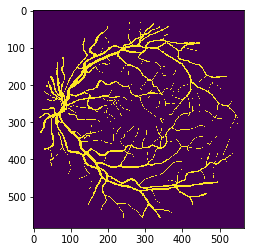

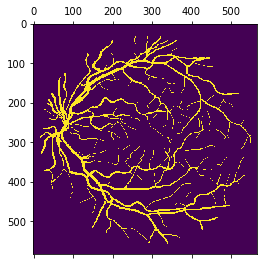

In [3]:
# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = convertImageToMatrix(test_manual1_images)
test_manual2_matrices = convertImageToMatrix(test_manual2_images)
test_raw_matrices = convertImageToMatrix(test_raw_images)
test_mask_matrices = convertImageToMatrix(test_mask_images)

plt.imshow(test_manual1_images[0]) #testing
test1 = test_manual1_matrices[0]
print test1[200,100] #255 = vessel; 0 = non-vessel
plt.matshow(test_manual1_matrices[0])

# All training image lists
training_manual1_images = loadData('training', '1st_manual')
training_raw_images = loadData('training', 'images')
training_mask_images = loadData('training', 'mask')

# Making matrices of the training images to work with
training_manual1_matrices = convertImageToMatrix(training_manual1_images)
training_raw_matrices = convertImageToMatrix(training_raw_images)
training_mask_matrices = convertImageToMatrix(training_mask_images)

The matrices are then used for further preprocessing to retrieve the suitable data for machine learning

In [4]:
#Choose the number of images
nr_images = 2
kernel_size = 25

#NOW TEST IMAGES ARE USED, CHANGE TO TRAINING MATRICES 
# Prepares the data for machine learning: X = image_patches, y = output_array = labels if center pixel is vessel or not
# Both are a list with the patches and output_arrays for multiple images (the number chosen before)
image_patches, output_array = prepareMultipleImages(test_raw_matrices[0:nr_images], test_manual1_matrices[0:nr_images], 
                                                     test_mask_matrices[0:nr_images], kernel_size)
print len(image_patches[0])
print len(output_array[0])

Progress: 50 % Progress: 100 % 224377
224377


The following code is just to show how the data set is built up. There are patches of 25x25 pixels. These values either correspond to a vessel pixel or not.

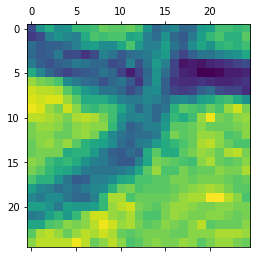

0
Should center pixel be vessel pixel? 255 (255 is yes, 0 is no)


In [5]:
image_number = 0
pixel = 19987 #35645, 35620

plt.matshow(image_patches[image_number][pixel])
plt.show()
#print image_patches[image_number][pixel]
print output_array[0][0]
print("Should center pixel be vessel pixel? " + str(output_array[image_number][pixel]) + " (255 is yes, 0 is no)")

In [6]:
# TESTING how the patching works 
output_matrix=np.array([[1,2,3,4,5,6],[7,8,9,12,11,13],[14,15,16,17,18,19],[4,2,3,4,2,6],[1,2,5,6,4,7]])
matrix_reduction = 1
reduced_output_matrix = output_matrix[matrix_reduction : - matrix_reduction, matrix_reduction : - matrix_reduction]
complete_output_array = reduced_output_matrix.reshape(-1)
print output_matrix
print reduced_output_matrix
print complete_output_array
all_image_patches = sklearn_image.extract_patches_2d(output_matrix,(2,2))
print all_image_patches

[[ 1  2  3  4  5  6]
 [ 7  8  9 12 11 13]
 [14 15 16 17 18 19]
 [ 4  2  3  4  2  6]
 [ 1  2  5  6  4  7]]
[[ 8  9 12 11]
 [15 16 17 18]
 [ 2  3  4  2]]
[ 8  9 12 11 15 16 17 18  2  3  4  2]
[[[ 1  2]
  [ 7  8]]

 [[ 2  3]
  [ 8  9]]

 [[ 3  4]
  [ 9 12]]

 [[ 4  5]
  [12 11]]

 [[ 5  6]
  [11 13]]

 [[ 7  8]
  [14 15]]

 [[ 8  9]
  [15 16]]

 [[ 9 12]
  [16 17]]

 [[12 11]
  [17 18]]

 [[11 13]
  [18 19]]

 [[14 15]
  [ 4  2]]

 [[15 16]
  [ 2  3]]

 [[16 17]
  [ 3  4]]

 [[17 18]
  [ 4  2]]

 [[18 19]
  [ 2  6]]

 [[ 4  2]
  [ 1  2]]

 [[ 2  3]
  [ 2  5]]

 [[ 3  4]
  [ 5  6]]

 [[ 4  2]
  [ 6  4]]

 [[ 2  6]
  [ 4  7]]]


In [7]:
def buildLeNet(X1):
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 25, 25),input_var=X1)    
    #print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    #print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    #print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    #print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    #print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    #print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    #print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    #print layer6.output_shape 
    
    #On output layer we need classification of all the pixels in field of view to vessel or non-vessel
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)     
    #print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

In [8]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

In [9]:
outputtrain = lasagne.layers.get_output(outputlayer) #function that gets the output from the network defined before.
trainloss = lasagne.objectives.categorical_crossentropy(outputtrain, Y).mean() #function that computes the mean crossentropy between the output and the real labels.
params = lasagne.layers.get_all_params(outputlayer, trainable=True) #function that gets all the parameters (weights) in the network.
updates = lasagne.updates.momentum(trainloss, params, learning_rate=0.001) #function that performs an update of the weights based on the loss.
train = theano.function(inputs=[X, Y], outputs=trainloss, updates=updates, allow_input_downcast=True) #function that does all the above based on training samples X and real labels Y.

C:\Users\Atte\Anaconda2\lib\site-packages\lasagne\layers\conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [10]:
validate = theano.function(inputs=[X, Y], outputs=trainloss, allow_input_downcast=True) #function that computes the loss without performing an update

In [11]:
outputtest = lasagne.layers.get_output(outputlayer, deterministic=True) #function that gets the output from the network defined before.
test = theano.function(inputs=[X], outputs=outputtest, allow_input_downcast=True) #function that gets the output based on input X

Training the network

In [12]:
all_output_arrays = []
length1 = length2 = 0
for i in xrange(nr_images):
    length1 = length1 + len(image_patches[i]) # Amount of pixels for each image; append to get all training pixels in same list
    length2 = length2 + len(output_array[i])     # Amount of pixels for each label (manual); actually this is same as trainingsamples in this case
    all_output_arrays = np.concatenate((all_output_arrays,output_array[i]),axis=0)
    
trainingsamples = np.arange(length1)  
validsamples = np.arange(length2)
print trainingsamples
print len(all_output_arrays)

#Do one-hot-encoding
labels = np.zeros((len(trainingsamples),2),dtype=np.int16) #0=pixel is not vessel, 1 = it's vessel
index1 = np.where(all_output_arrays == 0)  
labels[index1,0] = 1
index2 = np.where(all_output_arrays == 255) 
labels[index2,1] = 1
      
print labels[100:120]
print labels.shape

#validlabels = np.zeros((len(valid_set_labels),10),dtype=np.int16)  #USE manual2 segmentation for this??      
#for n in xrange(10):
#    validlabels[:,n] = valid_set_labels==n
validlabels = labels #for testing use just the same labels
    
minibatches = 5000
minibatchsize = 100 

losslist = []
validlosslist = []

t0 = time.time()

for i in xrange(minibatches):
    #select random training and validation samples and perform training and validation steps here    
    minibatchsamples = random.sample(trainingsamples,minibatchsize)  
    #determine which image and which pixel these minibatchsamples correspond
    loss = train(image_patches[minibatchsamples,:,:],output_array[minibatchsamples])
    if (i+1)%100==0:
        print 'Loss minibatch {}: {}'.format(i,loss)
    losslist.append(loss)        

    #validminibatchsamples = random.sample(validsamples,minibatchsize)           
    #validloss = validate(valid_set_images[validminibatchsamples],validlabels[validminibatchsamples])
    #if (i+1)%100==0:
     #   print 'Loss validation minibatch {}: {}'.format(i,validloss)
    #validlosslist.append(validloss)

t1 = time.time()
print 'Training time: {} seconds'.format(t1-t0)

[     0      1      2 ..., 449414 449415 449416]
449417
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
(449417L, 2L)
[379497, 340637, 189012, 116361, 229775, 181984, 352252, 136313, 214190, 262181, 408121, 226814, 126662, 339671, 277905, 112581, 408855, 441680, 364125, 405448, 139385, 327998, 403953, 307394, 212188, 45256, 195124, 274542, 410322, 434409, 214376, 388884, 117069, 361793, 246594, 6310, 323447, 179238, 370699, 300279, 513, 221822, 389915, 109617, 146152, 391204, 85868, 255048, 107238, 434829, 360962, 201325, 36153, 143837, 228277, 419231, 49012, 247748, 317540, 246029, 366035, 242812, 433165, 271081, 264085, 199985, 267981, 172981, 258707, 130479, 85115, 83919, 275390, 295113, 214161, 40368, 340480, 394035, 414983, 378615, 403654, 414848, 242954, 175855, 316966, 123874, 364759, 381773, 402245, 265066, 426840, 260524, 202490, 296725, 447735, 412088, 356533, 37019, 275395, 218616]


TypeError: list indices must be integers, not tuple

[[0 0]
 [0 0]]
224377
